# TODO: Explore Multicollinearity

# 1. Προετοιμασία δεδομένων

Import τα απατούμενα packages της Python

In [1]:
import pandas as pd

import re

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps

import torch
from torch import nn

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from tqdm.notebook import tqdm

from collections import Counter

# from google.colab import drive
# drive.mount('/content/drive')

### 1.1 Φόρτωση των δεδομένων

In [2]:
df = pd.read_excel('movies.xlsx')
pd.set_option('display.max_columns', None)

# Truncate
pd.set_option('display.max_rows', None) # Change False to None to not truncate

### 1.2 Γενική εικόνα των δεδομένων

In [3]:
df.head()

,Film,Year,Script Type,Rotten Tomatoes critics,Metacritic critics,Average critics,Rotten Tomatoes Audience,Metacritic Audience,Rotten Tomatoes vs Metacritic deviance,Average audience,Audience vs Critics deviance,Primary Genre,Genre,Opening Weekend,Opening weekend ($million),Domestic Gross,Domestic gross ($million),Foreign Gross ($million),Foreign Gross,Worldwide Gross,Worldwide Gross ($million),of Gross earned abroad,Budget ($million),Budget recovered,Budget recovered opening weekend,Distributor,IMDb Rating,IMDB vs RT disparity,Release Date (US),Oscar Winners,Oscar Detail
0,300,2007,adaptation,60,51,56,89.0,71,18,80,-25,action,"period, action",70885301,70.89,210614939,210.61,245.45,245453242,456068181,456.0,53.82%,65,701.64%,109.05%,NaN,NaN,NaN,"Mar 9, 2007",NaN,NaN
1,3:10 to Yuma,2007,remake,88,76,82,86.0,73,13,80,3,western,western,14035033,14.04,53606916,53.61,16.17,16173815,69780731,70.0,23.18%,50,139.56%,28.07%,NaN,NaN,NaN,"Sep 7, 2007",NaN,NaN
2,30 Days of Night,2007,adaptation,50,53,52,56.0,65,-9,61,-9,horror,horror,15951902,15.95,39568996,39.57,35.53,35526091,75095087,75.0,47.31%,32,234.67%,49.85%,NaN,NaN,NaN,"Oct 19, 2007",NaN,NaN
3,Across the Universe,2007,original screenplay,54,56,55,82.0,73,9,78,-23,musical,musical,3824988,3.82,24343673,24.34,5.02,5023470,29367143,29.0,17.11%,45,65.26%,8.50%,NaN,NaN,NaN,"Oct 12, 2007",NaN,NaN
4,Alien vs. Predator - Requiem,2007,sequel,14,29,22,31.0,45,-14,38,-17,sci-fi,"sci-fi, horror",10059425,10.06,41797066,41.80,87.09,87086650,128883716,129.0,67.57%,40,322.21%,25.15%,NaN,NaN,NaN,"Dec 25, 2007",NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402 entries, 0 to 1401
Data columns (total 31 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Film                                     1402 non-null   object 
 1   Year                                     1402 non-null   int64  
 2   Script Type                              1402 non-null   object 
 3   Rotten Tomatoes  critics                 1401 non-null   object 
 4   Metacritic  critics                      1402 non-null   object 
 5   Average critics                          1402 non-null   object 
 6   Rotten Tomatoes Audience                 1401 non-null   float64
 7   Metacritic Audience                      1402 non-null   object 
 8   Rotten Tomatoes vs Metacritic  deviance  1402 non-null   object 
 9   Average audience                         1402 non-null   object 
 10  Audience vs Critics deviance             1402 no

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,1402.0,2012.140514,3.190291,2007.0,2009.0000,2012.000,2015.0000,2017.00
Rotten Tomatoes Audience,1401.0,62.122769,17.435737,17.0,49.0000,62.000,76.0000,98.00
Opening weekend ($million),1402.0,23.200357,28.547541,0.0,6.6025,14.200,28.5975,247.97
Domestic gross ($million),1402.0,74.058024,87.389737,0.0,21.0900,44.045,92.5900,936.66
Worldwide Gross ($million),1402.0,173.008302,233.859025,0.0,38.0000,88.690,208.7500,2781.50
Distributor,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMDb Rating,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMDB vs RT disparity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.describe(include='object').T

,count,unique,top,freq
Film,1402,1396,Big Miracle,2
Script Type,1402,17,original screenplay,546
Rotten Tomatoes critics,1401,102,93,29
Metacritic critics,1402,90,51,39
Average critics,1402,196,64,25
Metacritic Audience,1402,78,66,50
Rotten Tomatoes vs Metacritic deviance,1402,82,-1,58
Average audience,1402,116,58,45
Audience vs Critics deviance,1402,78,-5,54
Primary Genre,19,11,comedy,5


# 2. Data cleanup

## 2.1 Έλεγχος για διπλότυπα

Το μόνο που μας ενδιαφέρει είναι το όνομα της ταινίας

In [7]:
df[df.duplicated(subset=['Film'], keep=False)]

,Film,Year,Script Type,Rotten Tomatoes critics,Metacritic critics,Average critics,Rotten Tomatoes Audience,Metacritic Audience,Rotten Tomatoes vs Metacritic deviance,Average audience,Audience vs Critics deviance,Primary Genre,Genre,Opening Weekend,Opening weekend ($million),Domestic Gross,Domestic gross ($million),Foreign Gross ($million),Foreign Gross,Worldwide Gross,Worldwide Gross ($million),of Gross earned abroad,Budget ($million),Budget recovered,Budget recovered opening weekend,Distributor,IMDb Rating,IMDB vs RT disparity,Release Date (US),Oscar Winners,Oscar Detail
681,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.45,36931089,36.93,20.79,20788004,57719093,58.00,36.02%,70,82.46%,19.22%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
682,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.00,36931089,37.00,20.79,20788004,57719093,58.00,36.02%,70,82.46,18.57%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
703,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,7.76,20157300,20.16,4.56,4561915,24719215,25.00,18.45%,40,61.80%,19.40%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
704,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,8.00,20157300,20.00,4.56,4561915,24719215,25.00,18.45%,40,61.8,20.00%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
709,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.00,20275446,20.00,10.81,10808153,31083599,31.00,34.77%,35,88.81,17.14%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
710,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.03,20275446,20.28,10.81,10808153,31083599,31.00,34.77%,35,88.81%,17.23%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
713,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,0.74,16377274,16.38,11.88,11880786,28258060,28.00,42.04%,32,88.31%,2.30%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
714,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,1.00,16377274,16.00,11.88,11880786,28258060,28.00,42.04%,32,88.31,3.13%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
1001,The Good Dinosaur,2015,original screenplay,77,66,72,66.0,70,-4,68,4,NaN,Adventure,39155217,39.00,123087120,123.09,209.12,209120551,332207671,332.21,62.95%,200,166%,19.58%,NaN,NaN,NaN,"Nov 25, 2015",NaN,NaN
1062,The Big Short,2015,adaptation,87,81,84,89.0,89,0,89,-5,NaN,drama,10531026,10.53,60900477,60.90,41.80,41800000,102700477,103.00,40.70%,28,366.79%,37.61%,NaN,NaN,NaN,"December 11, 2015",NaN,NaN


Διαγραφή διπλότυπων

In [8]:
df = df.drop_duplicates(subset=['Film'])

In [9]:
# Print lines with missing values
df[df['Rotten Tomatoes  critics'].isnull() | df['Rotten Tomatoes Audience '].isnull() | df['Genre'].isnull() | df.isin(['-']).any(axis=1)]

,Film,Year,Script Type,Rotten Tomatoes critics,Metacritic critics,Average critics,Rotten Tomatoes Audience,Metacritic Audience,Rotten Tomatoes vs Metacritic deviance,Average audience,Audience vs Critics deviance,Primary Genre,Genre,Opening Weekend,Opening weekend ($million),Domestic Gross,Domestic gross ($million),Foreign Gross ($million),Foreign Gross,Worldwide Gross,Worldwide Gross ($million),of Gross earned abroad,Budget ($million),Budget recovered,Budget recovered opening weekend,Distributor,IMDb Rating,IMDB vs RT disparity,Release Date (US),Oscar Winners,Oscar Detail
504,Paranormal Activity 2,2010,sequel,NaN,53,53,NaN,58,-58,58,-5,NaN,horror,40670000,40.67,84750000,84.75,92.76,92760000,"177,510,000",177.51,52.26%,3,5917.00%,1355.67%,NaN,NaN,NaN,"Oct 22, 2010",NaN,NaN
930,Deliver Us From Evil,2014,adaptation,28,40,34,42.0,59,-17,51,-17,NaN,NaN,9740471,9.74,30477122,30.48,57.36,57360693,87937815,88.00,65.23%,30,293.13%,32.47%,NaN,NaN,NaN,"Jul 2, 2014",NaN,NaN
1268,Baahubali 2: The Conclusion,2017,sequel,100,-,-,87.0,85,2,86,-,NaN,"action, adventure",10430497,10.43,20186659,20.19,121.32,121319777,141506436,141.51,85.73%,39,362.84%,26.74%,NaN,NaN,NaN,"Apr 28, 2017",NaN,NaN
1272,Beatriz At Dinner,2017,original screenplay,75,68,72,56.0,52,4,54,18,NaN,comedy,141959,0.14,7115854,7.12,0.00,0,7115854,7.12,0.00%,-,-,-,NaN,NaN,NaN,"Jun 9, 2017",NaN,NaN
1317,Let there be Light,2017,original screenplay,60,-,-,78.0,55,23,67,-,NaN,drama,1729535,1.73,7184198,7.18,0.00,0,7184198,7.18,0.00%,3,239.47%,57.65%,NaN,NaN,NaN,"Nov 10, 2017",NaN,NaN
1322,Lowriders,2017,original screenplay,55,57,56,63.0,-,-,-,-,NaN,drama,2403885,2.40,6179955,6.18,0.00,0,6179955,6.18,0.00%,1,686.66%,267.10%,NaN,NaN,NaN,"May 12, 2017",NaN,NaN
1325,Megan Leavey,2017,based on a true story,84,66,75,83.0,65,18,74,1,NaN,drama,3810867,3.81,13406883,13.41,0.00,0,13406883,13.41,0.00%,-,-,-,NaN,NaN,NaN,"Jun 9, 2017",NaN,NaN
1367,The Glass Castle,2017,"adaptation, based on a true story",49,56,53,74.0,63,11,69,-16,NaN,drama,4678548,4.68,17273059,17.27,4.50,4497986,21771045,21.77,20.66%,-,-,-,NaN,NaN,NaN,"Aug 11, 2017",NaN,NaN
1375,The Man Who Invented Christmas,2017,"adaptation, based on a true story",80,60,70,84.0,61,23,73,-3,NaN,drama,1353297,1.35,4664004,4.66,0.00,0,4664004,4.66,0.00%,-,-,-,NaN,NaN,NaN,"Nov 22, 2017",NaN,NaN
1388,Til Death Do Us Part,2017,original screenplay,-,-,-,64.0,-,-,-,-,NaN,thriller,1527289,1.53,3455267,3.46,0.00,0,3455267,3.46,0.00%,-,-,-,NaN,NaN,NaN,"Sep 29, 2017",NaN,NaN


In [10]:
# Drop lines that contain null or invalid values
df = df.dropna(subset=['Genre', 'Rotten Tomatoes  critics', 'Rotten Tomatoes Audience '])
df = df[~df.isin(['-']).any(axis=1)]

## 2.4 Outlier detection

In [11]:
#Remove decimal points and percent symbols from numerical strings
df[['Rotten Tomatoes  critics', 'Metacritic  critics', 'Average critics ', 'Rotten Tomatoes Audience ', 'Metacritic Audience ', 'Rotten Tomatoes vs Metacritic  deviance',
    'Average audience ', 'Audience vs Critics deviance ', 'Opening Weekend', 'Opening weekend ($million)', 'Domestic Gross', 'Domestic gross ($million)', 'Foreign Gross ($million)',
    'Foreign Gross', 'Worldwide Gross', 'Worldwide Gross ($million)', ' of Gross earned abroad', 'Budget ($million)', ' Budget recovered', ' Budget recovered opening weekend', 'IMDb Rating','IMDB vs RT disparity']] = df[[
                'Rotten Tomatoes  critics', 'Metacritic  critics', 'Average critics ', 'Rotten Tomatoes Audience ', 'Metacritic Audience ', 'Rotten Tomatoes vs Metacritic  deviance',
                'Average audience ', 'Audience vs Critics deviance ', 'Opening Weekend', 'Opening weekend ($million)', 'Domestic Gross', 'Domestic gross ($million)', 'Foreign Gross ($million)',
                'Foreign Gross', 'Worldwide Gross', 'Worldwide Gross ($million)', ' of Gross earned abroad', 'Budget ($million)', ' Budget recovered', ' Budget recovered opening weekend', 'IMDb Rating','IMDB vs RT disparity']].replace(',','', regex=True)

df = df.replace('%','', regex=True)

In [12]:
# Convert strings to numerical values
df[['Rotten Tomatoes  critics',
 'Metacritic  critics',
 'Average critics ',
 'Rotten Tomatoes Audience ',
 'Metacritic Audience ',
 'Rotten Tomatoes vs Metacritic  deviance',
 'Average audience ',
 'Audience vs Critics deviance ',
 'Opening Weekend',
 'Opening weekend ($million)',
 'Domestic Gross',
 'Domestic gross ($million)',
 'Foreign Gross ($million)',
 'Foreign Gross',
 'Worldwide Gross',
 'Worldwide Gross ($million)',
 ' of Gross earned abroad',
 'Budget ($million)',
 ' Budget recovered',
 ' Budget recovered opening weekend',
 'IMDb Rating',
 'IMDB vs RT disparity']] = df[['Rotten Tomatoes  critics',
                                'Metacritic  critics',
                                'Average critics ',
                                'Rotten Tomatoes Audience ',
                                'Metacritic Audience ',
                                'Rotten Tomatoes vs Metacritic  deviance',
                                'Average audience ',
                                'Audience vs Critics deviance ',
                                'Opening Weekend',
                                'Opening weekend ($million)',
                                'Domestic Gross',
                                'Domestic gross ($million)',
                                'Foreign Gross ($million)',
                                'Foreign Gross',
                                'Worldwide Gross',
                                'Worldwide Gross ($million)',
                                ' of Gross earned abroad',
                                'Budget ($million)',
                                ' Budget recovered',
                                ' Budget recovered opening weekend',
                                'IMDb Rating',
                                'IMDB vs RT disparity']].apply(pd.to_numeric)

# Convert Oscar Winners to 1 hot encoding
df['Oscar Winners'] = df["Oscar Winners"].notnull().astype("int")

In [13]:
# Detect critic values outside normal range
df[(df['Rotten Tomatoes Audience '] < 0) | (df['Rotten Tomatoes Audience '] > 100) | (df['Rotten Tomatoes  critics'] < 0) | (df['Rotten Tomatoes  critics'] > 100)
   | (df['Metacritic  critics'] < 0 ) | (df['Metacritic  critics'] > 100) |  (df['Metacritic Audience '] < 0 ) | (df['Metacritic Audience ']) > 100].sum()

Film                                         0
Year                                         0
Script Type                                  0
Rotten Tomatoes  critics                     0
Metacritic  critics                          0
Average critics                            0.0
Rotten Tomatoes Audience                   0.0
Metacritic Audience                          0
Rotten Tomatoes vs Metacritic  deviance      0
Average audience                           0.0
Audience vs Critics deviance                 0
Primary Genre                                0
Genre                                        0
Opening Weekend                              0
Opening weekend ($million)                 0.0
Domestic Gross                               0
Domestic gross ($million)                  0.0
Foreign Gross ($million)                   0.0
Foreign Gross                              0.0
Worldwide Gross                              0
Worldwide Gross ($million)                 0.0
 of Gross ear

#### Calculate budget columns with 0 with the correct values

In [14]:
df.loc[(df['Opening weekend ($million)'] == 0), 'Opening weekend ($million)'] = df.loc[(df['Opening weekend ($million)'] == 0), 'Opening Weekend'] / 1000
df.loc[(df['Domestic gross ($million)'] == 0), 'Domestic gross ($million)'] = df.loc[(df['Domestic gross ($million)'] == 0), 'Domestic Gross'] / 1000
df.loc[(df['Foreign Gross ($million)'] == 0), 'Foreign Gross ($million)'] = df.loc[(df['Foreign Gross ($million)'] == 0), 'Foreign Gross'] / 1000
df.loc[(df['Worldwide Gross ($million)'] == 0), 'Worldwide Gross ($million)'] = df.loc[(df['Worldwide Gross ($million)'] == 0), 'Worldwide Gross'] / 1000

#### Detect outliers in budgets

In [15]:
#TODO fix it
Q1 = df['Budget ($million)'].quantile(0.25)
Q3 = df['Budget ($million)'].quantile(0.75)

IQR = Q3 - Q1
threshold = 5

outliers = df[(df['Budget ($million)'] < Q1 - threshold * IQR) | (df['Budget ($million)'] > Q3 + threshold * IQR)]
outliers

df.at[outliers['Budget ($million)'].index[0], 'Budget ($million)'] = df.at[outliers['Budget ($million)'].index[0], 'Budget ($million)'] / 1000

In [16]:
df.at[outliers['Budget ($million)'].index[0], 'Budget ($million)']

52.274

In [17]:
# Conver ' of Gross earned abroad' values to 0-1 range since '%' is removed
df[' of Gross earned abroad'] = df[' of Gross earned abroad'].apply(lambda s: s / 100)

#### Drop any remaining rows with 0 budget than can not be fixed

In [18]:
df = df[df['Foreign Gross ($million)'] != 0]
df = df[df[' of Gross earned abroad'] != 0]

### Cleaned dataset properties

In [19]:
df = df.reset_index()
df = df.drop(['index'],axis=1)
df.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
Year,1333.00,2011.95,3.11,2007.00,2009.00,2012.00,2015.00,2017.00
Rotten Tomatoes critics,1333.00,52.86,27.47,0.00,28.00,53.00,78.00,99.00
Metacritic critics,1333.00,53.48,17.34,9.00,41.00,53.00,66.00,100.00
Average critics,1333.00,53.40,22.09,6.00,35.00,53.00,71.00,99.00
Rotten Tomatoes Audience,1333.00,62.06,17.23,19.00,49.00,62.00,76.00,98.00
Metacritic Audience,1333.00,62.96,13.38,9.00,54.00,64.00,73.00,92.00
Rotten Tomatoes vs Metacritic deviance,1333.00,-0.89,11.84,-52.00,-9.00,-1.00,6.00,45.00
Average audience,1333.00,62.74,14.24,15.50,52.50,63.00,73.00,93.00
Audience vs Critics deviance,1333.00,-9.48,13.77,-48.00,-20.00,-9.00,0.00,33.00
Opening Weekend,1333.00,24064992.61,28925331.46,8682.00,7480927.00,14860425.00,29300000.00,247966675.00


# 3. Feature exploration

## 3.1 Dataset preprocessing

#### Convert `script type` and `genre` to 1 hot encoding

In [20]:
# Make a copy of dataframe
df_cl = df

In [21]:
# from sklearn.preprocessing import OneHotEncoder
#TODO use sklearn one hot encoder


In [22]:
# Convert strings to lowercase
df_cl['Script Type'] = df_cl['Script Type'].str.lower()

# Extract all unique script type names
script_types = df_cl['Script Type'].unique()

# Split strings and remove trailing spaces
types = []
for string in script_types:
    types.append(re.split(' / |, ',string))
script_types = [j.strip() for sub in types for j in sub]

#Convert to set to remove dublicates
unique_script_types = set(script_types)

# Insert columns for each coresponding script type
for i, item in enumerate(unique_script_types):
    # df.insert(i+1, 'st_'+item, 0)
    # df.insert(-1, 'st_'+item, 0)
    df_cl.insert(i, 'st_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for script in unique_script_types:
        if script in df_cl.at[i, 'Script Type']:
            df_cl.at[i, 'st_'+script] = 1

# Drop script type and primary genre columns from dataframe
df_cl = df_cl.drop(['Script Type'], axis=1)

In [23]:
# TODO: Use spellchecking to remove invalid genres

# Convert genres to lower to avoid possible dublication
df_cl['Genre'] = df_cl['Genre'].str.lower()
genres = df_cl['Genre'].unique()

# Split strings and remove trailing spaces
unique_genres = []
for string in genres:
    unique_genres.append(re.split(', |. ',string))
genre_types = [j.strip() for sub in unique_genres for j in sub]

#Convert to set to remove dublicates
genre_types = set(genre_types)


# Remove invalid values
genre_types.remove('')
genre_types.remove('adventur')
genre_types.remove('biograph')
genre_types.remove('comed')
genre_types.remove('crim')
genre_types.remove('documentar')
genre_types.remove('dram')
genre_types.remove('famiily')
genre_types.remove('famil')
genre_types.remove('fantas')
genre_types.remove('horro')
genre_types.remove('musi')
genre_types.remove('music')
genre_types.remove('myster')
genre_types.remove('romanti')
genre_types.remove('sci-f')
genre_types.remove('sport')
genre_types.remove('thriler')
genre_types.remove('thrille')

# Insert columns for each coresponding script type
for i, item in enumerate(genre_types):
    # df.insert(i+9, 'gen_'+item, 0)
    df_cl.insert(i, 'gen_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for genre in genre_types:
        if genre in df_cl.at[i, 'Genre']:
            df_cl.at[i, 'gen_'+genre] = 1

# Drop original genre column
df_cl = df_cl.drop(['Genre'], axis=1)

In [24]:
# Drop unecessary primary genre
df_cl = df_cl.drop(['Primary Genre'], axis=1)

## Dataset overview

In [25]:
df_cl.head().T

,0,1,2,3,4
gen_war,0,0,0,0,0
gen_fantasy,0,0,0,0,0
gen_documentary,0,0,0,0,0
gen_crime,0,0,0,0,0
gen_biography,0,0,0,0,0
gen_sports,0,0,0,0,0
gen_period,1,0,0,0,0
gen_horror,0,0,1,0,1
gen_musical,0,0,0,1,0
gen_animation,0,0,0,0,0


## 3.2 Correlation analysis

### 3.2.1 Feature correlation to oscar winners

<Axes: xlabel='Correlation to Oscar Winners', ylabel='Features'>

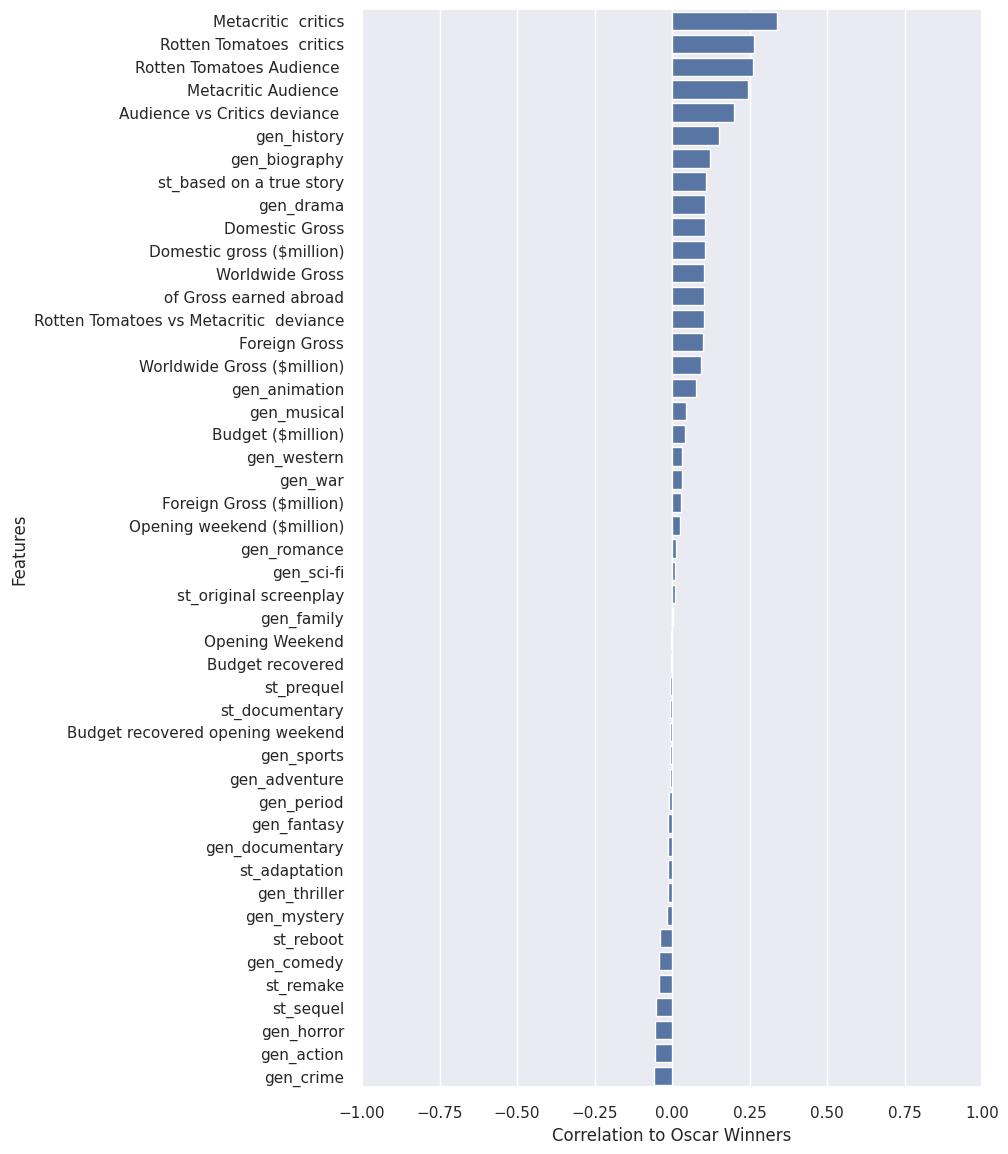

In [193]:
# remove non relevant columns
# df_cl_corr = df_cl.drop(['Film', 'Year','Distributor', 'IMDb Rating', 'IMDB vs RT disparity', 'Release Date (US)','Oscar Detail'], axis=1)

# Remove non relevant columns and average critics columns
df_cl_corr = df_cl.drop(['Film', 'Year','Distributor', 'IMDb Rating', 'IMDB vs RT disparity', 'Release Date (US)','Oscar Detail' , 'Average critics ', 'Average audience '], axis=1)

# Calculate correlation values and grab last row
corr = df_cl_corr.corr()
last_row = pd.DataFrame(corr.iloc[-1, :-1]).sort_values(by='Oscar Winners', ascending=False)

sns.set_theme()
plt.figure(figsize=(8, 14))
plt.xlabel('Correlation to Oscar Winners')
plt.ylabel('Features')
plt.xlim(-1, 1)
sns.barplot(data=last_row, x='Oscar Winners', y=last_row.index)

### 3.2.2 Calculate VIF values to detect multicollinearity problems

In [212]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
  
# creating dummies for gender 
  
# the independent variables set 
X = df_cl_corr.drop(['Oscar Winners'], axis=1)
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
vif_data["VIF"] = vif_data["VIF"].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

vif_data

/home/mike/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
33,Rotten Tomatoes vs Metacritic deviance,inf
32,Metacritic Audience,inf
31,Rotten Tomatoes Audience,inf
29,Rotten Tomatoes critics,11201.77
30,Metacritic critics,10263.70
41,Worldwide Gross,3548.80
34,Audience vs Critics deviance,3465.94
40,Foreign Gross,1601.11
37,Domestic Gross,628.22
46,Budget recovered opening weekend,408.95


Remove high VIF variables and recalculate VIF

In [241]:
df_cl_corr.columns

Index(['gen_war', 'gen_fantasy', 'gen_documentary', 'gen_crime',
       'gen_biography', 'gen_sports', 'gen_period', 'gen_horror',
       'gen_musical', 'gen_animation', 'gen_sci-fi', 'gen_action',
       'gen_history', 'gen_comedy', 'gen_drama', 'gen_romance', 'gen_mystery',
       'gen_family', 'gen_adventure', 'gen_thriller', 'gen_western',
       'st_original screenplay', 'st_prequel', 'st_remake', 'st_sequel',
       'st_based on a true story', 'st_documentary', 'st_adaptation',
       'st_reboot', 'Rotten Tomatoes  critics', 'Metacritic  critics',
       'Rotten Tomatoes Audience ', 'Metacritic Audience ',
       'Rotten Tomatoes vs Metacritic  deviance',
       'Audience vs Critics deviance ', 'Opening Weekend',
       'Opening weekend ($million)', 'Domestic Gross',
       'Domestic gross ($million)', 'Foreign Gross ($million)',
       'Foreign Gross', 'Worldwide Gross', 'Worldwide Gross ($million)',
       ' of Gross earned abroad', 'Budget ($million)', ' Budget recovered',
   

In [253]:
# df_cl_corr_reduced = df_cl_corr.drop(['Metacritic Audience ', 'Metacritic  critics', 'Audience vs Critics deviance ', 'Domestic Gross', ' Budget recovered opening weekend', 'Worldwide Gross ($million)','Foreign Gross'], axis=1)
# the independent variables set 
df_cl_corr_reduced = df_cl_corr.drop(['Rotten Tomatoes vs Metacritic  deviance', 'Metacritic Audience ', 'Worldwide Gross', ' Budget recovered opening weekend', 'Rotten Tomatoes Audience ', 'Domestic Gross', 'Metacritic  critics', 'Opening Weekend', 'Domestic gross ($million)'], axis=1)
X = df_cl_corr_reduced
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
vif_data["VIF"] = vif_data["VIF"].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

vif_data

,feature,VIF
29,Rotten Tomatoes critics,12.45
33,Foreign Gross,11.96
34,Worldwide Gross ($million),10.89
21,st_original screenplay,9.40
27,st_adaptation,7.89
35,of Gross earned abroad,7.44
23,st_remake,7.23
28,st_reboot,6.51
36,Budget ($million),6.45
31,Opening weekend ($million),4.70


### 3.2.3 Correlation Matrix
Remove low correlation values to oscar winners and plot correlation matrix to detext multicolinearity problems

Text(0.5, 1.0, 'Correlation Matrix')

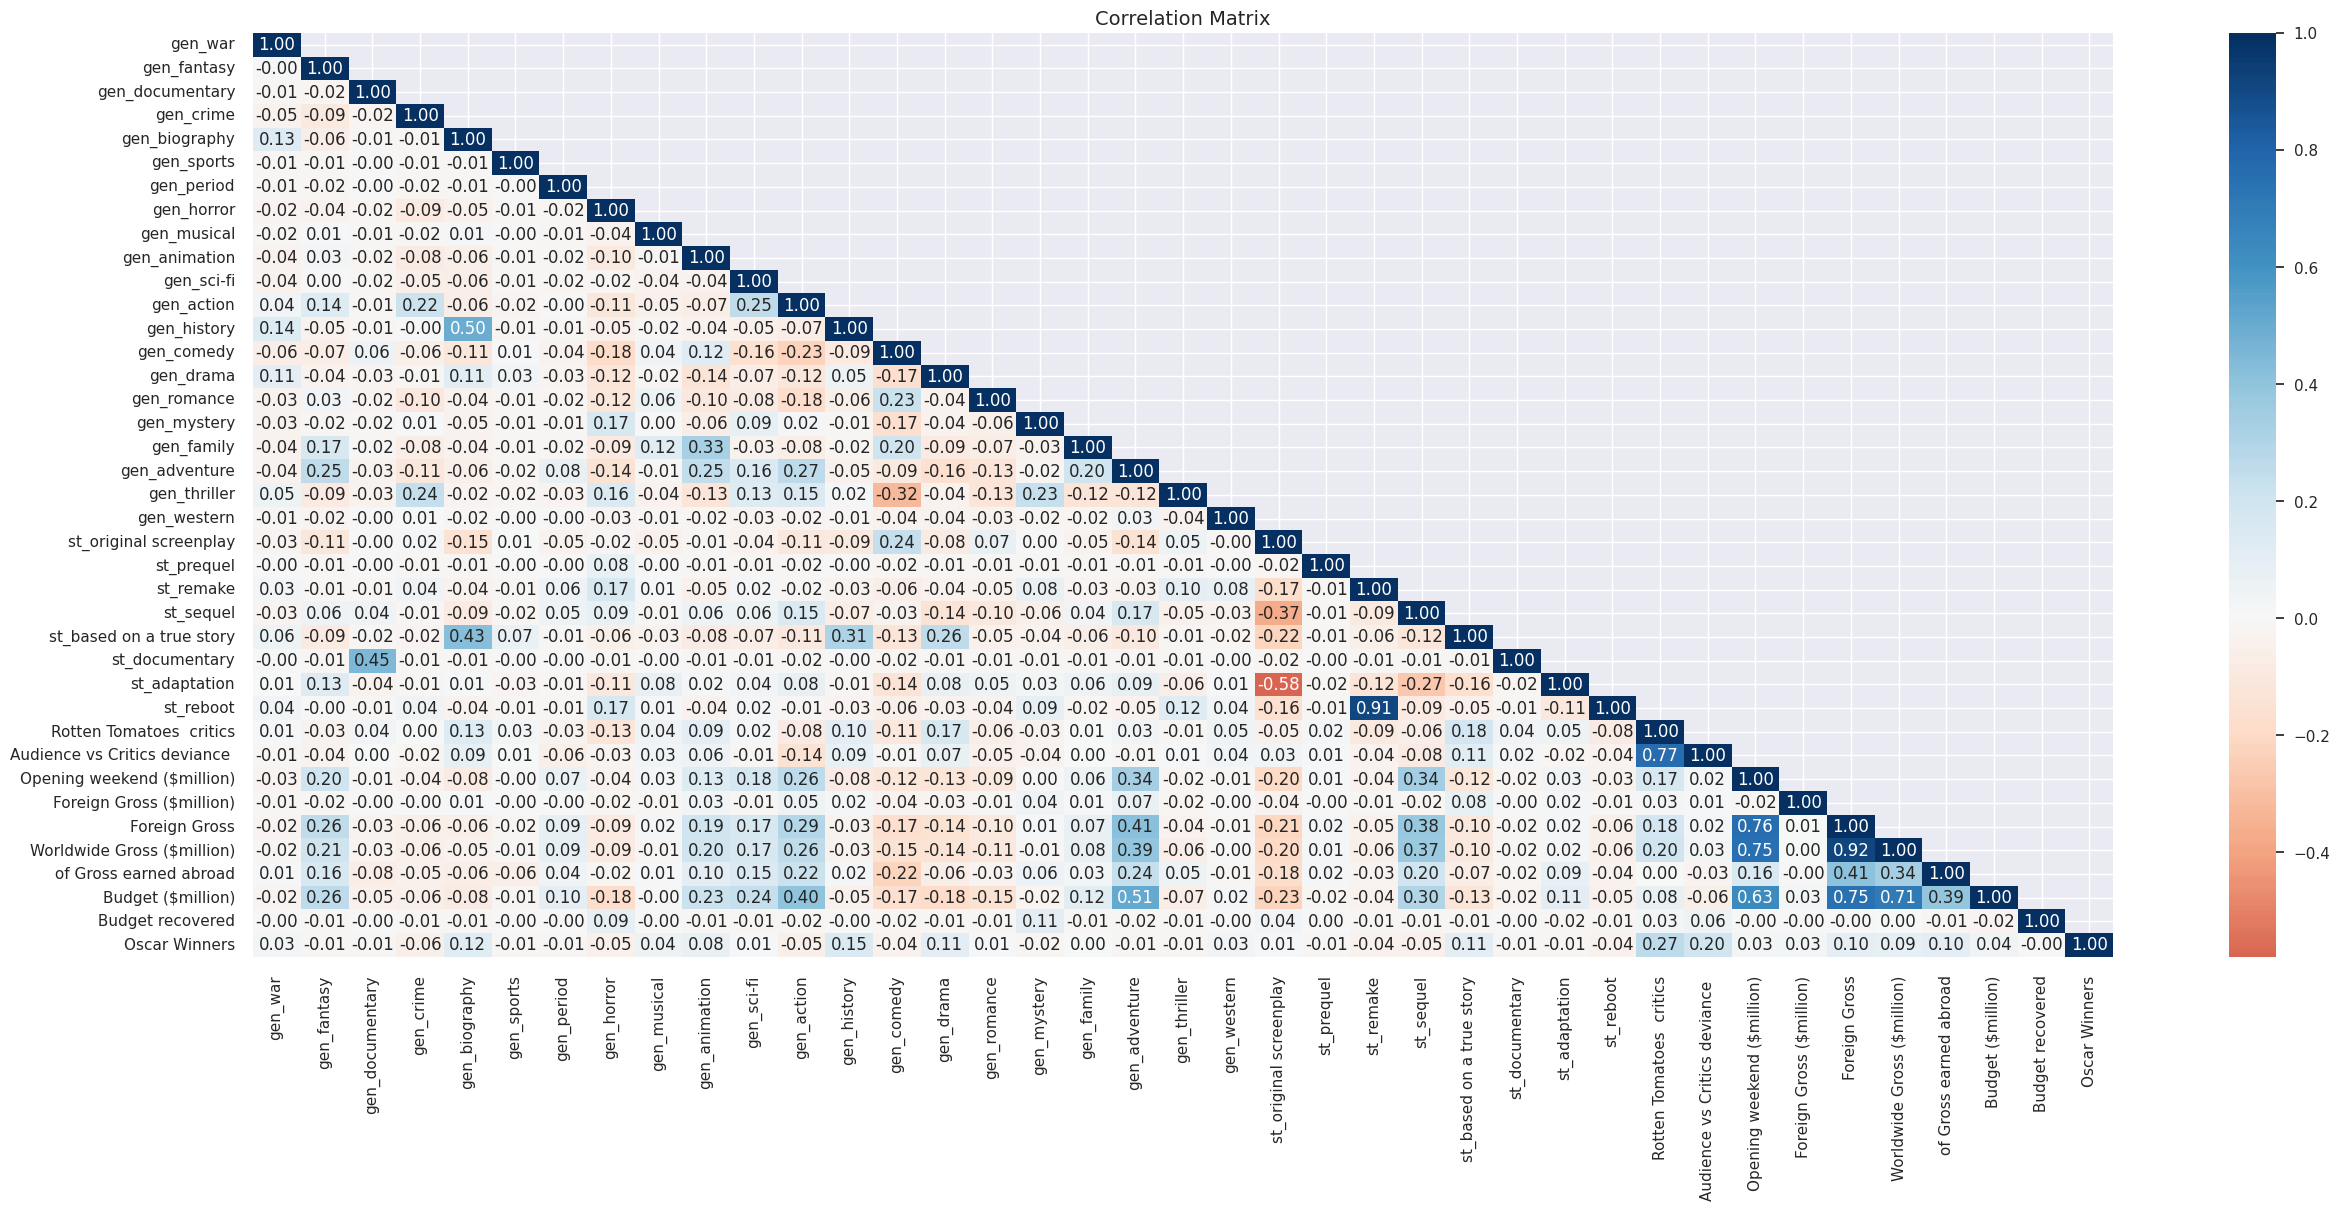

In [254]:
# Plot correlation matrix
# df_cl_corr_less = df_cl_corr[['Metacritic  critics', 'Rotten Tomatoes  critics','Rotten Tomatoes Audience ','Metacritic Audience ', 'Oscar Winners']]
df_cl_corr_less =df_cl_corr_reduced
corr_mat = df_cl_corr_less.corr()

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask, k=1)] = True

sns.set_theme()
plt.figure(figsize=(30, 12))
sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f')
plt.title('Correlation Matrix', fontsize=14)

#### Basic scatterplot of critics and audience scores

<Axes: title={'center': 'Budget vs Worlwide gross income ($millions)'}, xlabel='Budget ($million)', ylabel='Worldwide Gross ($million)'>

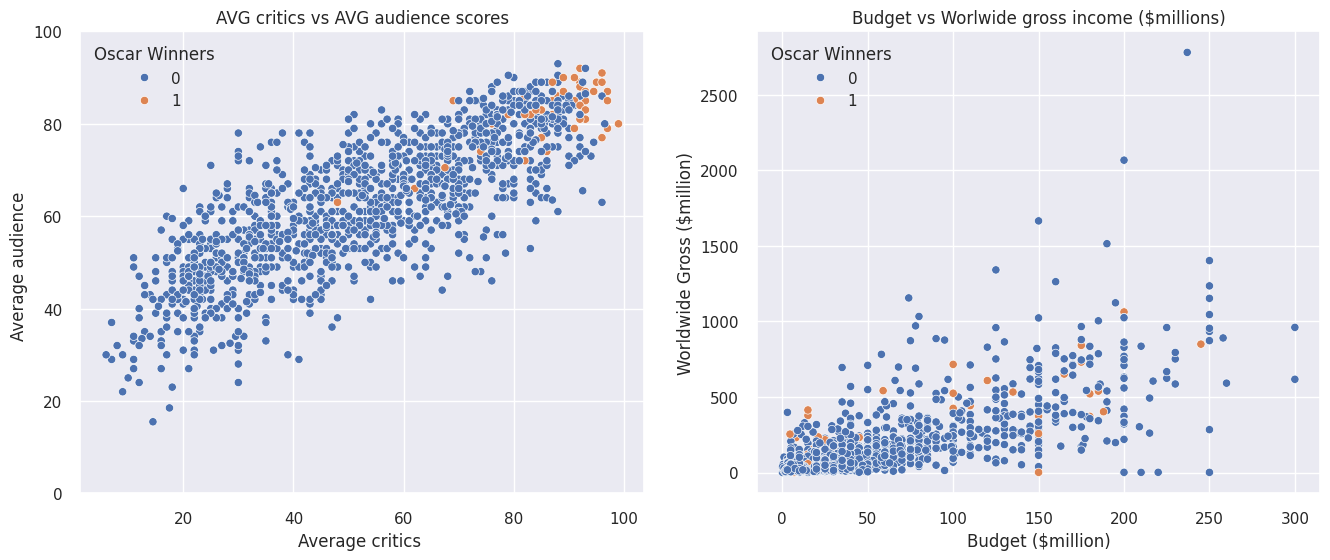

In [223]:
sns.set_theme()
# sns.set_style("whitegrid")
fig, ax =plt.subplots(1,2)
fig.set_figwidth(16)
fig.set_figheight(6)
ax[0].set_title('AVG critics vs AVG audience scores')
ax[0].set_ylim(0, 100)
ax[1].set_title('Budget vs Worlwide gross income ($millions)')
sns.scatterplot(data=df_cl, x='Average critics ', y='Average audience ', hue='Oscar Winners', ax=ax[0])
sns.scatterplot(data=df_cl, x='Budget ($million)', y='Worldwide Gross ($million)', hue='Oscar Winners', ax=ax[1])

In [224]:
# x = df_cl.drop(['Oscar Winners', 'Film', 'Year', 'Release Date (US)', 'Oscar Detail', 'Distributor', 'IMDb Rating', 'IMDB vs RT disparity', 'Release Date (US)'], axis=1)
y = df_cl[['Oscar Winners']]
meta = df_cl['Film']

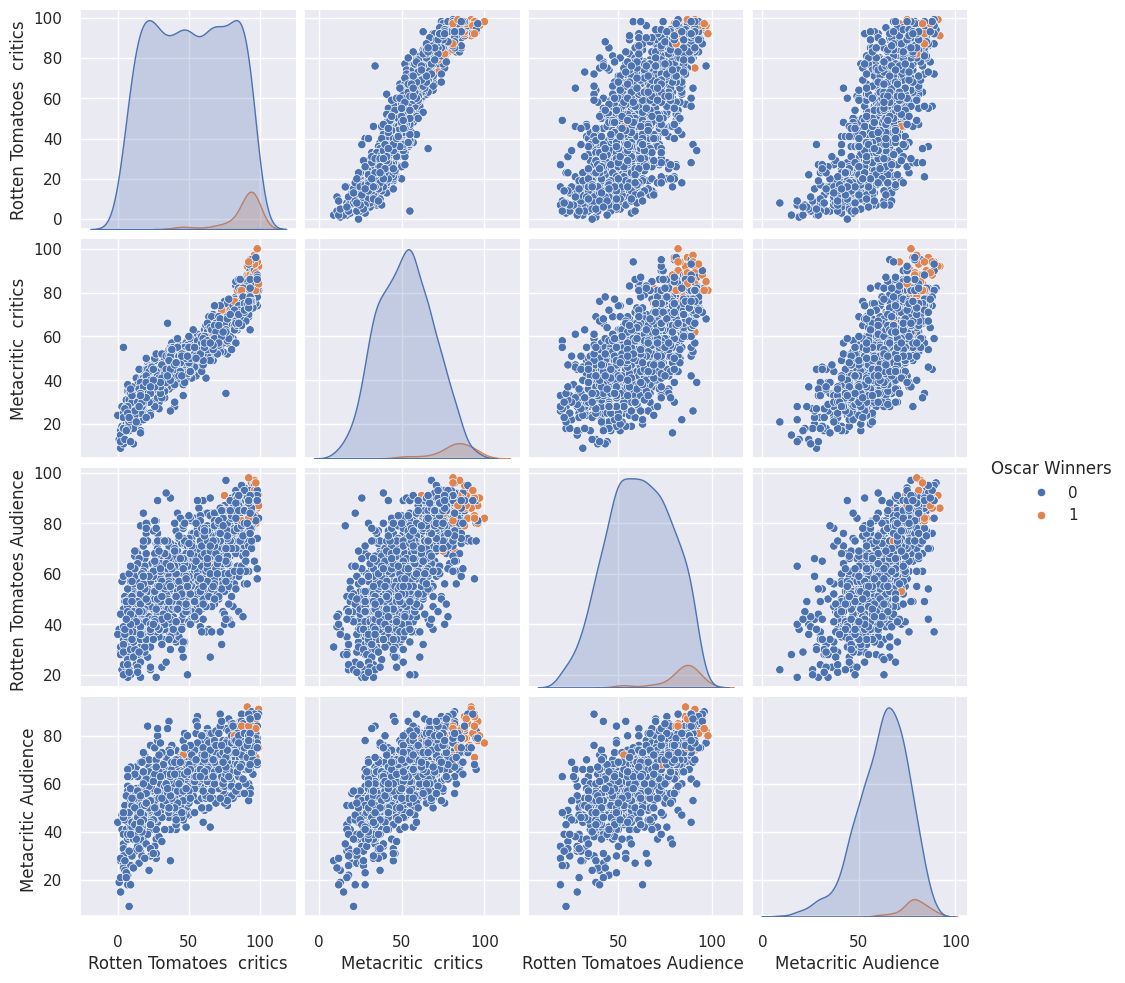

In [255]:
pairplt = df_cl[['Rotten Tomatoes  critics', 'Metacritic  critics', 'Rotten Tomatoes Audience ', 'Metacritic Audience ']]
sns.pairplot(pd.concat([pairplt, y], axis=1), hue='Oscar Winners')

## 3.3 Principle Components Analysis

#### Calculate most important principal components

Text(0.5, 1.0, 'Scree plot')

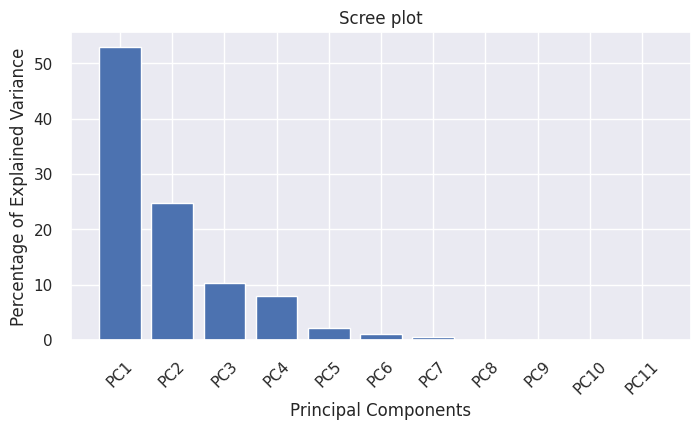

In [256]:
# Select features for PCA analysis
x = df_cl[['Rotten Tomatoes  critics', 'Metacritic  critics', 'Average critics ', 'Rotten Tomatoes Audience ', 'Metacritic Audience ', 'Average audience ', 'Audience vs Critics deviance ','Domestic Gross', 'Foreign Gross', 'Worldwide Gross', ' of Gross earned abroad']]

# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df[['Oscar Winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(8,4))
plt.xticks(rotation=45)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')

Text(0, 0.5, 'Cumulative explanied variance')

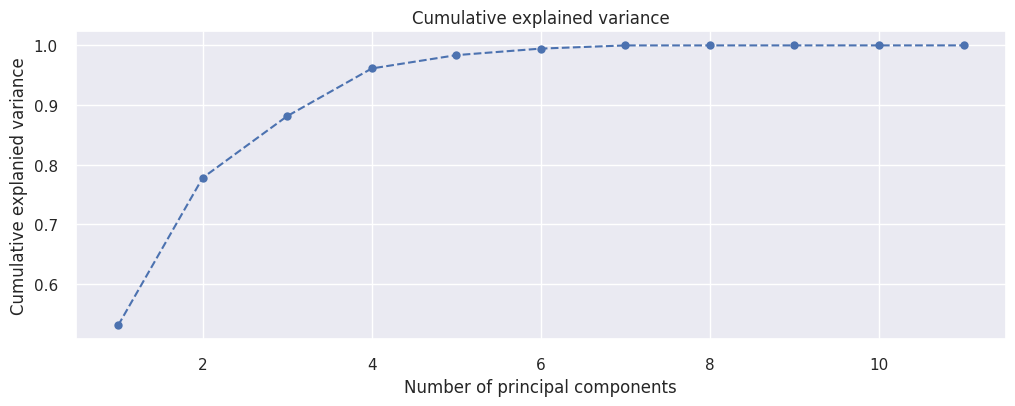

In [227]:
sns.set_theme()
plt.figure(figsize= (12,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')

<Axes: xlabel='PC1 - 53.02%', ylabel='PC2 - 24.76%'>

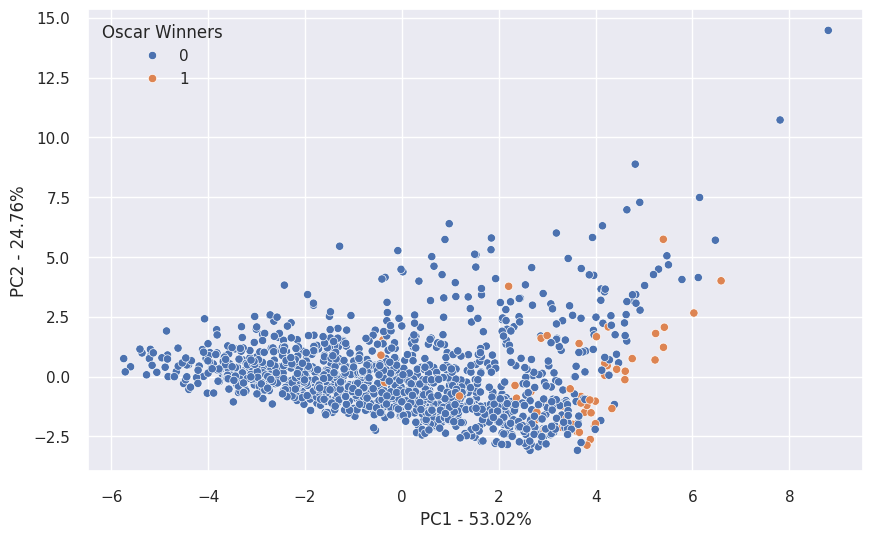

In [228]:
sns.set_theme()
plt.figure(figsize=(10, 6))
plt.xlabel(f'PC1 - {per_var[0]}%')
plt.ylabel(f'PC2 - {per_var[1]}%')
sns.scatterplot(data=final_df, x="PC1", y='PC2', hue='Oscar Winners')

#### Recalculating PCA with most important principal components

In [229]:
pca = PCA(n_components=4)
principal_components = pca.fit_transform(x)

## 3.4 Clustering

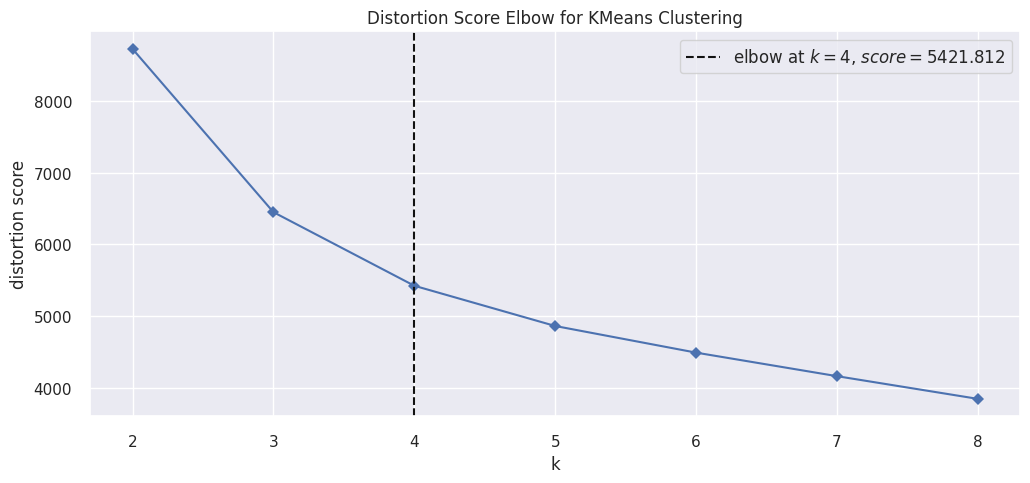

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [230]:
# Set plot style, and background color
sns.set_theme()
# sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
# sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=42)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=8, timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(principal_components)

# Finalize and render the figure
visualizer.show()

In [36]:
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.head()

,0,1,2,3
0,1.681184,1.878610,-1.748924,-0.141346
1,2.632567,-1.942094,-0.414276,-0.698131
2,-0.431365,-0.665775,0.029975,0.202199
3,0.512520,-1.265782,-2.167283,-0.587150
4,-3.631595,0.891980,0.941894,0.624355


In [37]:
N_CLUSTERS = 4

# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=N_CLUSTERS, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans.fit(principal_components_df)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)
print(cluster_frequencies)
# for item in cluster_frequencies:
#     print(item)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {0: 0, 1: 1, 2: 2, 3: 3}.items()}
# label_mapping = {v: k for k, v in {0: 0, 1: 1, 2: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
# customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
principal_components_df = pd.concat([principal_components_df, y], axis = 1)

principal_components_df['cluster'] = new_labels



Counter({2: 470, 1: 373, 3: 359, 0: 131})


In [38]:
cluster_dict = {}

for i in range(len(label_mapping)):
    cluster_dict[i] = 0

for item in principal_components_df.values:
    if item[-2] == 1:
        cluster_dict[item[-1]] = cluster_dict[item[-1]] +1
print(cluster_dict)

{0: 14, 1: 0, 2: 3, 3: 37}


<BarContainer object of 4 artists>

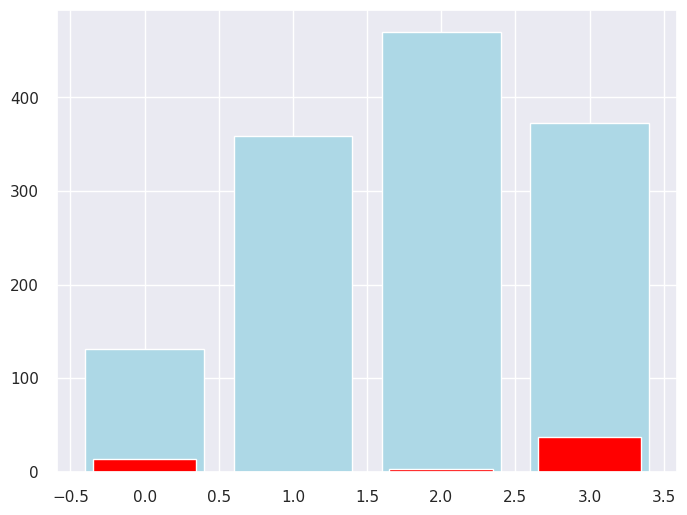

In [39]:
labels = []
for item in set(kmeans.labels_):
    labels.append(item)

numbers = []
for key in cluster_frequencies:
     numbers.append(cluster_frequencies[key])

oscar = []
for key in cluster_dict:
     oscar.append(cluster_dict[key])
     
sns.set_theme()
plt.figure(figsize=(8,6))
plt.bar(labels, numbers, color='lightblue')
plt.bar(labels, oscar, width=0.7, color='red')

# 4. Prediction models

TODO:
- Use another model like 'tree'
- Run models many times and take average scores and construct AOC curves

## 4.1 Neural Network classification model

### 4.1.1 Prepare dataset
Feature selection

In [40]:
# remove unecessesary features from dataset
# df = df.drop(['Film','Year','Script Type','Opening Weekend', 'Domestic Gross', 'Foreign Gross', 'Worldwide Gross', 'Rotten Tomatoes vs Metacritic  deviance', 'Audience vs Critics deviance ', 'Worldwide Gross ($million)', ' of Gross earned abroad', 'Average audience ', 'Average critics ', ' Budget recovered', ' Budget recovered opening weekend'], axis=1)
df_nn = df[['Rotten Tomatoes  critics', 'Metacritic  critics', 'Rotten Tomatoes Audience ','Metacritic Audience ', 'Oscar Winners']]

#### Balance classes

In [41]:
# Select all oscar winning movies
df_oscar_winners = df_nn[df_nn['Oscar Winners'] == 1]

# Pick a random subset from non oscar winning movies
df_no_oscar_winners = df_nn[df_nn['Oscar Winners'] == 0].sample(len(df_oscar_winners) * 2)

frames = [df_oscar_winners, df_no_oscar_winners]

df_nn = pd.concat(frames)
df_nn = df_nn.sample(frac=1) # Shuffle rows

#### Training and testing splits

In [42]:
# Train test split with stratify
features = df_nn.drop(['Oscar Winners'], axis=1)
labels = df_nn['Oscar Winners']

X = torch.from_numpy(features.to_numpy(dtype='float32'))
y = torch.from_numpy(labels.to_numpy(dtype='float32')).unsqueeze(dim=1)

print(f'Shapes: X: {X.shape}, y: {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Shapes: X: torch.Size([162, 4]), y: torch.Size([162, 1])


In [43]:
# Check stratification (FOR DEBUGGING. WILL BE REMOVED LATER)
train = 0
for item in y_train:
    if item.item() == 1:
        train += 1

test = 0
for item in y_test:
    if item.item() == 1:
        test += 1

print(f'Oscar winners in training labels: {train}\nOscar winners in testing labels: {test}')

Oscar winners in training labels: 38
Oscar winners in testing labels: 16


In [44]:
# Check tensor dtypes FOR DEBUGGING
print(f'Check tensors data types:\n{X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype}')

Check tensors data types:
(torch.float32, torch.float32, torch.float32, torch.float32)


### 4.1.2 Define PyTorch classes and functions

#### Define NN Classification model

In [45]:
class OscarClassification(nn.Module):
    def __init__(self, input_features: int, output_features: int):
        super(OscarClassification, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=output_features)
        )

    # Not using sigmoid here when use BCEWithLogits loss function
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

#### Define train and test functions

In [46]:
def train(model, loss_fn, optimizer, accuracy_fn, X_train, y_train, X_test, y_test, epochs, device, seed=None, verbose=False):
    if seed != None:
        torch.manual_seed(seed)

    epochs = epochs
    
    X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)
    
    model.train()

    # for epoch in tqdm(range(epochs), desc='Training...'):
    for epoch in range(epochs):
        y_pred = model(X_train).to(device)

        loss = loss_fn(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate prediction accuracy
        y_train_pred = torch.round(torch.sigmoid(y_pred))
        acc = accuracy_fn(y_pred=y_train_pred, y_true=y_train)

        if verbose:
        ### Testing
            model.eval()
            with torch.inference_mode():
                y_pred_test = model(X_test)
                test_loss = loss_fn(y_pred_test, y_test)
                test_acc = accuracy_fn(y_pred=torch.round(torch.sigmoid(y_pred_test)), y_true=y_test)

            if epoch % int(epochs/10) == 0 or epoch == epochs-1:
                print(f'Epoch: {epoch:04d} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
            
    return acc

In [47]:
def test(model, accuracy_fn, X_test, y_test, device):
    with torch.inference_mode():
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_test_logits = model(X_test)
        y_test_probs = torch.sigmoid(y_test_logits)
        acc = accuracy_fn(y_pred=torch.round(y_test_probs), y_true=y_test)
    print(f'Test total accuracy: {acc:.2f}%')
    return y_test_probs, acc

#### Define loss function and set device

In [48]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(f'Device used: {device}')

# Initialize model
# model = OscarClassification(input_features=X_train.shape[1], output_features=1).to(device)

# Loss function
loss_fn = torch.nn.BCEWithLogitsLoss().to(device)

# Optimizer functions
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# optimizer= torch.optim.Adam(model.parameters(), lr=0.01)

Device used: cuda


#### Define helper functions

In [49]:
# Accuracy calculator helper function
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

### 4.2.2 Train NN model

Train models multiple times and calculate average accuracy for specific models

In [50]:
results = []
for i in tqdm(range(10)):
    # Initialize model and optimizer
    model = OscarClassification(input_features=X_train.shape[1], output_features=1).to(device)
    n_params = sum(p.numel() for p in model.parameters())
    optimizer= torch.optim.Adam(model.parameters(), lr=0.01)
    train(model, loss_fn, optimizer, accuracy_fn, X_train, y_train, X_test, y_test, 400, device, seed=None, verbose=False)
    y_pred, acc = test(model, accuracy_fn, X_test, y_test, device)
    # correct_oscar_guesses = count_oscars(y_pred, y_test)
    results.append({'model' : 'model_in-10-10-ep400', 
                    'model_params' : n_params, 
                    'accuracy' : acc, 
                    'preds' : y_pred.to('cpu').numpy(), 
                    'pred_oscar_count' : int(y_pred.sum().item()), 
                    'truth_oscar_count' : int(y_test.sum().item()) })

  0%|          | 0/10 [00:00<?, ?it/s]

Test total accuracy: 85.71%
Test total accuracy: 73.47%
Test total accuracy: 75.51%
Test total accuracy: 83.67%
Test total accuracy: 79.59%
Test total accuracy: 87.76%
Test total accuracy: 75.51%
Test total accuracy: 87.76%
Test total accuracy: 81.63%
Test total accuracy: 85.71%


#### Test accuracy on whole dataset

In [51]:
#TODO: above 

### 4.2.3 Result evaluations for best performing neural network model

In [52]:
best = max(results, key=lambda x:x['accuracy'])

#### AUC Curve

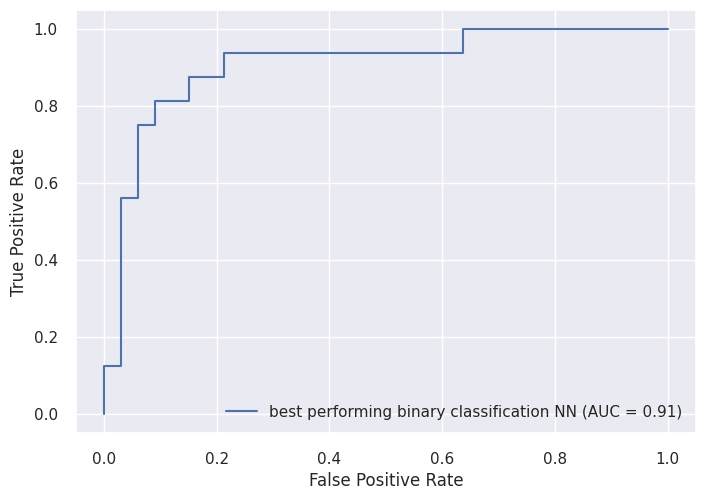

In [53]:
y_true = y_test.to('cpu').numpy().flatten()
y_pred = best['preds'].flatten()

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='best performing binary classification NN')
display.plot()
plt.show()

In [54]:
y_test, y_test_pred = y_test.to('cpu'), torch.round(torch.tensor((best['preds'])))
cf_matrix = confusion_matrix(y_test, y_test_pred)
print(cf_matrix)
print('\n')
print(classification_report(y_test, y_test_pred))

[[30  3]
 [ 3 13]]


              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91        33
         1.0       0.81      0.81      0.81        16

    accuracy                           0.88        49
   macro avg       0.86      0.86      0.86        49
weighted avg       0.88      0.88      0.88        49



#### Visualize metrics

<Axes: >

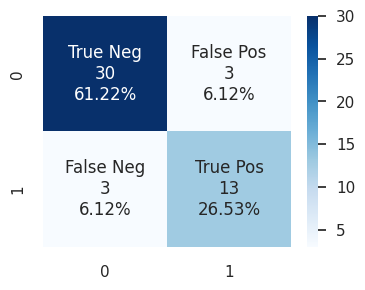

In [55]:
sns.set()
group_names = ['True Neg','False Pos','False Neg','True Pos']               
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(4, 3))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [56]:
pd.DataFrame(data=classification_report(y_test, y_test_pred, output_dict=True)).T

,precision,recall,f1-score,support
0.0,0.909091,0.909091,0.909091,33.000000
1.0,0.812500,0.812500,0.812500,16.000000
accuracy,0.877551,0.877551,0.877551,0.877551
macro avg,0.860795,0.860795,0.860795,49.000000
weighted avg,0.877551,0.877551,0.877551,49.000000


## 4.3 K-Nearest Neighbors classification model

In [57]:
df_knn = df_cl[['Rotten Tomatoes  critics', 'Metacritic  critics',
       'Rotten Tomatoes Audience ', 'Metacritic Audience ',
       'Opening weekend ($million)', 'Domestic gross ($million)',
       'Foreign Gross ($million)', 'Budget ($million)', 'Oscar Winners']]

In [58]:
df_knn.columns

Index(['Rotten Tomatoes  critics', 'Metacritic  critics',
       'Rotten Tomatoes Audience ', 'Metacritic Audience ',
       'Opening weekend ($million)', 'Domestic gross ($million)',
       'Foreign Gross ($million)', 'Budget ($million)', 'Oscar Winners'],
      dtype='object')

In [59]:
df_oscar_winners = df_knn[df_knn["Oscar Winners"] == 1]
print(df_oscar_winners.shape)

df_rest = df_knn[df_knn["Oscar Winners"] != 1]
df_rest = df_rest.sample(n=55, random_state=42)
print(df_rest.shape)

df_small = pd.concat([df_oscar_winners, df_rest], axis=0)
print(df_small.shape)

(54, 9)
(55, 9)
(109, 9)


In [60]:
X_knn = df_small.iloc[:, :-1].values
y_knn = df_small.iloc[:, -1].values

In [61]:
y_knn = y_knn.astype(str)

In [62]:
for index, label in enumerate(y_knn):
    if label == '1.0':
        y_knn[index] = 'Winner'
    elif label == '0.0':
        y_knn[index] = 'Not winner'

In [63]:
X_knn.shape, y_knn

((109, 8),
 array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
        '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
        '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
        '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
        '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0'], dtype='<U21'))

In [64]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_knn, y_knn, test_size=0.2, stratify=y_knn, random_state=42)

In [65]:
scaler = StandardScaler()

scaler.fit(X_train_knn)
X_train_knn = scaler.transform(X_train_knn)

X_test_knn = scaler.transform(X_test_knn)

In [66]:
k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_knn, y_knn, cv=5)
    scores.append(np.mean(score))

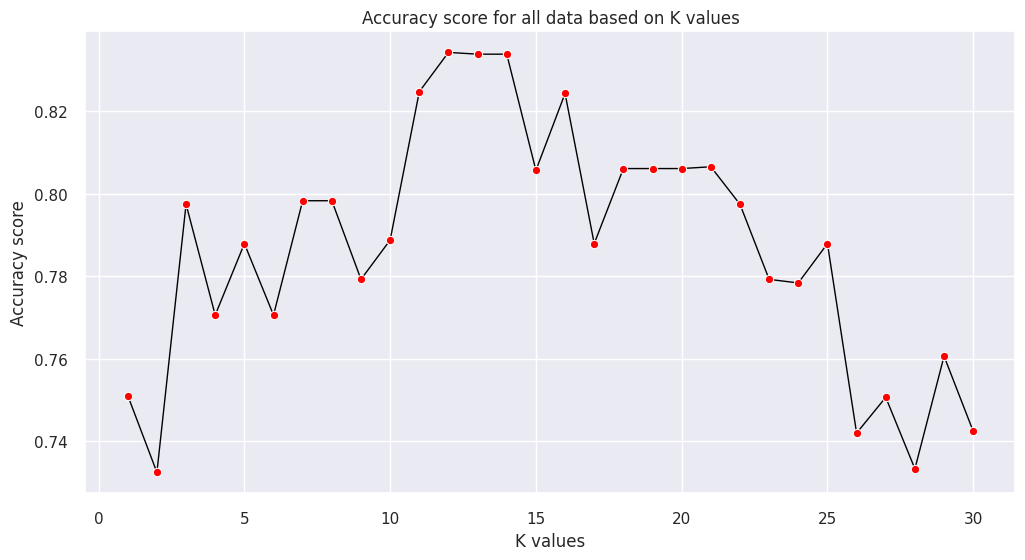

In [67]:
plt.figure(figsize=(12,6))
sns.lineplot(x = k_values, y = scores, marker='o', markerfacecolor='red', color='black', linewidth=1).set(title='Accuracy score for all data based on K values',
                                                                                       xlabel='K values',
                                                                                       ylabel='Accuracy score')
sns.set_theme(style='darkgrid', font_scale=1.25)
# sns.set(rc={'figure.facecolor':'lightgrey'})

In [68]:
best_index = np.argmax(scores)
best_k = k_values[best_index]
best_k

12

In [69]:
K = []
training = []
test = []
scores = {}

for k in range(1, 31):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train_knn, y_train_knn)

    training_score = clf.score(X_train_knn, y_train_knn)
    test_score = clf.score(X_test_knn, y_test_knn)
    K.append(k)

    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]

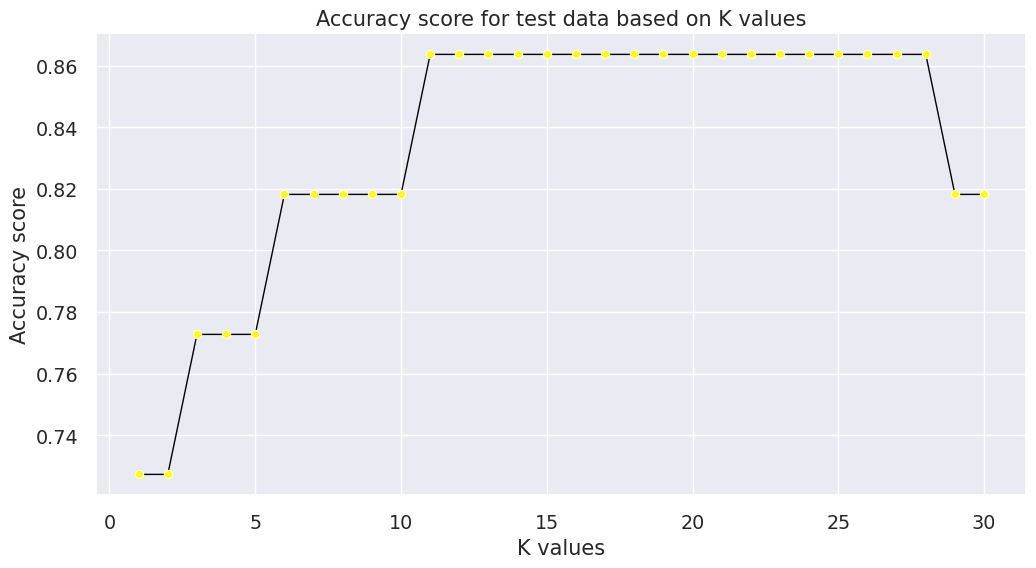

In [70]:
plt.figure(figsize=(12,6))
sns.lineplot(x = K, y = test, marker='o', markerfacecolor='yellow', color='black', linewidth=1).set(title='Accuracy score for test data based on K values',
                                                                                                              xlabel='K values',
                                                                                                              ylabel='Accuracy score')
sns.set_theme(style='darkgrid', font_scale=1.25)

In [71]:
best_index = np.argmax(scores)
best_k = k_values[best_index]
best_k

1

In [72]:
classifier_small = KNeighborsClassifier(n_neighbors=14)
classifier_small.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(n_neighbors=14)

In [73]:
y_preds_small = classifier_small.predict(X_test_knn)

In [74]:
from sklearn.metrics import classification_report, confusion_matrix

In [75]:
print(classification_report(y_test_knn, y_preds_small))
print(confusion_matrix(y_test_knn, y_preds_small))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.83      0.91      0.87        11

    accuracy                           0.86        22
   macro avg       0.87      0.86      0.86        22
weighted avg       0.87      0.86      0.86        22

[[ 9  2]
 [ 1 10]]


## 4.4 Model comparisson graphs
- TODO: Plot AUC curves for best performing experiment of each model
- TODO: Plot Average score (accuracy / correct oscar guesses) achieved for each type of model
- TODO: Plot based on confusion matric values

<Axes: >

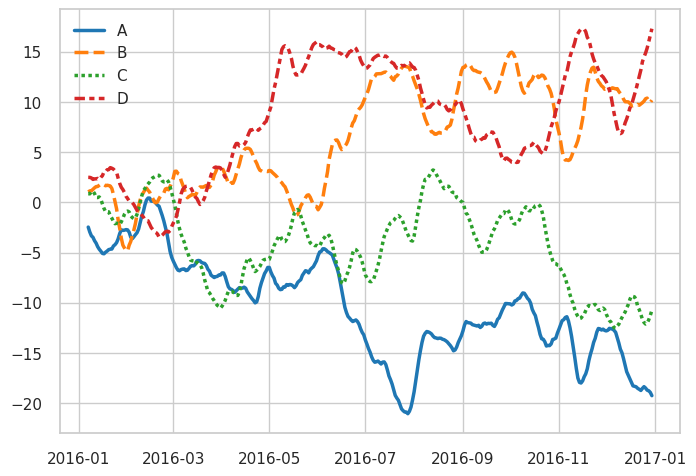

In [76]:
# Placeholder graph
sns.set_theme(style="whitegrid")

rs = np.random.RandomState(365)
values = rs.randn(365, 4).cumsum(axis=0)
dates = pd.date_range("1 1 2016", periods=365, freq="D")
data = pd.DataFrame(values, dates, columns=["A", "B", "C", "D"])
data = data.rolling(7).mean()

sns.lineplot(data=data, palette="tab10", linewidth=2.5)